# Set Up

- Install packages
- Set up BigQuery connection
- Set Visualiation Theme

In [2]:
import tqdm
import pandas_gbq
import numpy as np
import pandas as pd
import seaborn as sns
from google.oauth2 import service_account
import matplotlib.pyplot as plt

In [3]:
credentials = service_account.Credentials.from_service_account_file(
    'trumid-case-8a70bafcd63d.json',
)
pandas_gbq.context.credentials = credentials
# Update the in-memory credentials cache (added in pandas-gbq 0.7.0).
pandas_gbq.context.credentials = credentials
pandas_gbq.context.project = "trumid-case"

In [4]:
%matplotlib inline
sns.set_theme(style="whitegrid")

# Background & Objective
You are provided with datasets from TheLook, an eCommerce platform selling clothing. The
dataset encompasses various facets of the business including distribution centers, web events,
inventory, order items, orders, products, and user data. You can find the data [here](https://console.cloud.google.com/marketplace/product/bigquery-public-data/thelook-ecommerce?project=trumid-case) using
Google’s bigquery-public-data project. Access it by signing in with a Google/Gmail account.

Your task is not only to analyze the data but also to provide actionable business insights that
could guide TheLook's strategy to operate more optimally and enhance the overall customer
experience. Please prepare a response to each question below and be ready to discuss both
your answer and your thought process for each. The tools you use to perform the analysis and
present your results are up to you, but expect that the audience for your presentation will ask
you to walk through any queries, code, or formulas behind your numbers.

# Assessing Data Quality

Before moving forward, want to better understand the data and what, if any issues, may impact our ability to capture metrics

### In `products`, are both `ID` and `sku` unique? **Yes**

In [6]:
# Are skus and ids unique?
product_sku_count_sql = """
SELECT
    COUNT(DISTINCT id) AS unique_ids
    , COUNT(DISTINCT sku) unique_skus
    , COUNT(DISTINCT CONCAT(id,'-',sku)) as unique_ids
FROM
    `trumid-case.thelook_ecommerce.products`
"""
pandas_gbq.read_gbq(product_sku_count_sql)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,unique_ids,unique_skus,unique_ids_1
0,29120,29120,29120


### Does the `sale price` in `products` always match the `retail price` in `order items`? **Yes**

In [11]:
sale_price_check_sql = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku
    ,cost
    ,retail_price
FROM
    `trumid-case.thelook_ecommerce.products`
),
thelook_orderitems AS (
SELECT
    id as order_item_id
    ,order_id
    ,product_id
    ,sale_price
FROM
    `trumid-case.thelook_ecommerce.order_items`
),
thelook_inventory_items AS (
SELECT
    id as inventory_id
    ,product_id
    ,product_sku
    ,cost
FROM
    `trumid-case.thelook_ecommerce.inventory_items`
),
thelook_revenue AS (
SELECT
   thelook_products.product_id
   ,thelook_products.sku
   ,thelook_orderitems.order_item_id
   ,thelook_products.retail_price
   ,thelook_orderitems.sale_price
FROM
    thelook_products
INNER JOIN
    thelook_orderitems
ON
    thelook_products.product_id = thelook_orderitems.product_id
)
SELECT
    COUNT(*) AS count_price_difference
FROM
    thelook_revenue
WHERE
    retail_price != sale_price
"""
pandas_gbq.read_gbq(sale_price_check_sql)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,count_price_difference
0,0


### Is the cost in the `products` table ever different from the cost in the `inventory_items` table? **No**

In [7]:
product_cost_check_sql = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku
    ,cost
    ,retail_price
FROM
    `trumid-case.thelook_ecommerce.products`
),
thelook_orderitems AS (
SELECT
    id as order_item_id
    ,order_id
    ,product_id
    ,sale_price
FROM
    `trumid-case.thelook_ecommerce.order_items`
),
thelook_inventory_items AS (
SELECT
    id as inventory_id
    ,product_id
    ,product_sku
    ,cost
FROM
    `trumid-case.thelook_ecommerce.inventory_items`
),
thelook_cost AS (
SELECT
   thelook_products.product_id
   ,thelook_products.sku
   ,thelook_products.cost as product_cost
   ,thelook_inventory_items.inventory_id
   ,thelook_inventory_items.cost as inventory_cost
FROM
    thelook_products
INNER JOIN
    thelook_inventory_items
ON
    thelook_products.product_id = thelook_inventory_items.product_id
AND
    thelook_products.sku = thelook_inventory_items.product_sku
)
SELECT
    COUNT(*) AS count_cost_difference
FROM
    thelook_cost
WHERE
    product_cost != inventory_cost
"""
pandas_gbq.read_gbq(product_cost_check_sql)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,count_cost_difference
0,0


### Does every item in `order_items` have a corresponding record in `products`? **Yes**

In [15]:
# Is the order item sale ever different from the product list price?
order_item_products_sql = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku
    ,cost
    ,retail_price
FROM
    `trumid-case.thelook_ecommerce.products`
),
thelook_orderitems AS (
SELECT
    id as order_item_id
    ,inventory_item_id
    ,product_id
    ,sale_price
FROM
    `trumid-case.thelook_ecommerce.order_items`
),
thelook_inventory_items AS (
SELECT
    id as inventory_item_id
    ,product_id
    ,product_sku
    ,cost
FROM
    `trumid-case.thelook_ecommerce.inventory_items`
),
thelook_inventory_order AS (
SELECT
    thelook_products.product_id
    ,thelook_orderitems.order_item_id
FROM
    thelook_orderitems
LEFT JOIN
    thelook_products
ON
    thelook_products.product_id = thelook_orderitems.product_id
)
SELECT
    COUNT(CASE WHEN product_id IS NOT NULL THEN order_item_id ELSE NULL END) AS num_order_items_products
    ,COUNT(order_item_id) AS num_order_items
FROM
    thelook_inventory_order
"""
pandas_gbq.read_gbq(order_item_products_sql)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,num_order_items_products,num_order_items
0,182013,182013


### Does every item in `inventory_items` have a corresponding record in `products`? **Yes**

In [13]:
inventory_item_products_sql = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku
    ,cost
    ,retail_price
FROM
    `trumid-case.thelook_ecommerce.products`
),
thelook_orderitems AS (
SELECT
    id as order_item_id
    ,inventory_item_id
    ,product_id
    ,sale_price
FROM
    `trumid-case.thelook_ecommerce.order_items`
),
thelook_inventory_items AS (
SELECT
    id as inventory_item_id
    ,product_id
    ,product_sku
    ,cost
FROM
    `trumid-case.thelook_ecommerce.inventory_items`
),
thelook_inventory_order AS (
SELECT
    thelook_products.product_id
    ,thelook_inventory_items.inventory_item_id
FROM
    thelook_inventory_items
LEFT JOIN
    thelook_products
ON
    thelook_products.product_id = thelook_inventory_items.product_id
)
SELECT
    COUNT(CASE WHEN product_id IS NOT NULL THEN inventory_item_id ELSE NULL END) AS num_inventory_items_produccts
    ,COUNT(inventory_item_id) AS num_inventory_items
FROM
    thelook_inventory_order
"""
pandas_gbq.read_gbq(inventory_item_products_sql)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,num_inventory_items_produccts,num_inventory_items
0,491940,491940


### Does every item in `inventory_items` have a corresponding record in `order_items`?

In [14]:
# Is the order item sale ever different from the product list price?
inventory_order_item_check_sql = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku
    ,cost
    ,retail_price
FROM
    `trumid-case.thelook_ecommerce.products`
),
thelook_orderitems AS (
SELECT
    id as order_item_id
    ,inventory_item_id
    ,product_id
    ,sale_price
FROM
    `trumid-case.thelook_ecommerce.order_items`
),
thelook_inventory_items AS (
SELECT
    id as inventory_item_id
    ,product_id
    ,product_sku
    ,cost
FROM
    `trumid-case.thelook_ecommerce.inventory_items`
),
thelook_inventory_order AS (
SELECT
    thelook_inventory_items.inventory_item_id
    ,thelook_orderitems.order_item_id
FROM
    thelook_orderitems
LEFT JOIN
    thelook_inventory_items
ON
    thelook_inventory_items.inventory_item_id = thelook_orderitems.inventory_item_id
)
SELECT
    COUNT(DISTINCT inventory_item_id) AS num_inventory_items
    ,COUNT(CASE WHEN inventory_item_id IS NOT NULL THEN inventory_item_id ELSE NULL END) AS num_inventory_items_ordered
FROM
    thelook_inventory_order
"""
pandas_gbq.read_gbq(inventory_order_item_check_sql)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,num_inventory_items,num_inventory_items_ordered
0,182013,182013


### Can we trust `inventory_items` and `order_items` when joined together? **No**

- This shows that there's weirdness in how the IDs were generated.
- This dataset has ID integrity but it doesn't actually make sense when you join them.
    - The `sold_at` field exists for the correct number of `order_items` records but the IDs don't match
    - Cases exist where something is delivered but `is_sold` IS NULL, normally would ask engineering or product about it but those don't exist here

In [59]:
inventory_order_sql = """
WITH thelook_order_item_details AS (
SELECT
    inventory_items.product_category
    ,order_items.id AS order_item_id
    ,inventory_items.id AS inventory_item_id 
    ,order_items.user_id
    ,order_items.product_id
    ,order_items.sale_price AS item_sale_price
    ,inventory_items.cost AS item_cost
    ,inventory_items.sold_at
    ,CASE WHEN order_items.id IS NOT NULL THEN order_items.sale_price - inventory_items.cost ELSE NULL END AS item_profit
    ,inventory_items.created_at AS inventory_item_logged_at
    ,order_items.created_at AS order_item_placed_at
    ,order_items.shipped_at AS order_item_shipped_at
    ,order_items.returned_at AS order_item_returned_at
    ,orders.created_at AS order_placed_at
    ,order_items.status
    ,CASE WHEN order_items.created_at IS NOT NULL THEN TRUE ELSE FALSE END AS is_sold
    ,CASE WHEN order_items.returned_at IS NOT NULL THEN TRUE ELSE FALSE END AS was_returned
FROM
    `trumid-case.thelook_ecommerce.inventory_items`  AS inventory_items
LEFT JOIN
    `trumid-case.thelook_ecommerce.order_items`  AS order_items
ON
    inventory_items.id = order_items.inventory_item_id
AND
    inventory_items.product_id = order_items.product_id
LEFT JOIN
    `trumid-case.thelook_ecommerce.orders`  AS orders
ON
    order_items.order_id = orders.order_id
),
thelook_item_metrics AS (
SELECT
    product_category
    ,CASE WHEN order_item_id iS NULL THEN 0 ELSE order_item_id END AS order_item_id
    ,inventory_item_id
    ,inventory_item_logged_at
    ,order_item_shipped_at
    ,order_placed_at
    ,sold_at
    ,CASE WHEN sold_at IS NOT NULL THEN TRUE ELSE FALSE END AS sold_check
    ,status
    ,CASE 
        WHEN is_sold IS TRUE AND was_returned IS FALSE 
        THEN item_profit
        ELSE 0 END AS realized_item_profit
    ,CASE 
        WHEN is_sold IS TRUE AND was_returned IS FALSE 
        THEN DATE_DIFF(order_item_placed_at,inventory_item_logged_at,DAY) 
        ELSE NULL END AS days_to_turnover
FROM
    thelook_order_item_details
)
SELECT
    *
FROM 
    thelook_item_metrics
"""
order_inventory = pandas_gbq.read_gbq(inventory_order_sql)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [64]:
order_inventory.query("sold_check == True & order_item_id == 0").shape

(182013, 11)

In [65]:
order_inventory.query("order_item_id != 0 & sold_check == False").shape

(182013, 11)

In [56]:
pd.merge(order_inventory.query("sold_check == True"),order_inventory.query("order_item_id != 0 & sold_check == False"),on='order_item_id',how='inner')

,product_category_x,order_item_id,inventory_item_id_x,inventory_item_logged_at_x,order_item_shipped_at_x,order_placed_at_x,sold_at_x,sold_check_x,status_x,realized_item_profit_x,...,product_category_y,inventory_item_id_y,inventory_item_logged_at_y,order_item_shipped_at_y,order_placed_at_y,sold_at_y,sold_check_y,status_y,realized_item_profit_y,days_to_turnover_y


### Volume Sold by Status

In [78]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
status_sql = """
WITH thelook_order_items AS (
SELECT
    id as order_item_id
    ,product_id
    ,status
FROM
    `trumid-case.thelook_ecommerce.order_items`
)
SELECT
    status
    ,COUNT(order_item_id) AS quantity
FROM
    thelook_order_items
GROUP BY
    status
"""
volume_sold_by_status = pandas_gbq.read_gbq(status_sql)
volume_sold_by_status

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,status,quantity
0,Shipped,54192
1,Complete,45085
2,Processing,35913
3,Cancelled,27436
4,Returned,18294


# Question 1: 

Assess the profitability of each product category. Are there significant differences between
them? If so, what might TheLook consider changing about its product mix to increase margins
overall?

## Key Metrics
- Product Profit Margin: For each product, the difference between the retail price of an item and its cost divided by its retail price
- Gross Profit Margin: For each product category, the difference between the total revenue generated and the total cost of goods sold divided by the total revenue generated  
- Contribution to Profit: Profit generated by a given product category divided by the total profit
- Turnover (In Days): How long between when a product is added to inventory and it is sold?

## Recommendations

To increase overall margins, the company should look to:

* Sell fewer clothing sets, suits; they're high price items with lower profit margins and sold in low volume
* Sell more high margin items like active wear, blazers/jackets, and dresses; they're higher margins and higher prices that we could sell more of

## Analysis

### Analyzing Shelf Life

 *  What is the order workflow?
    * Processing -> Cancelled
    * Processing -> Shipped -> Delivered
    * Processing -> Shipped -> Delivered -> Returned 

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


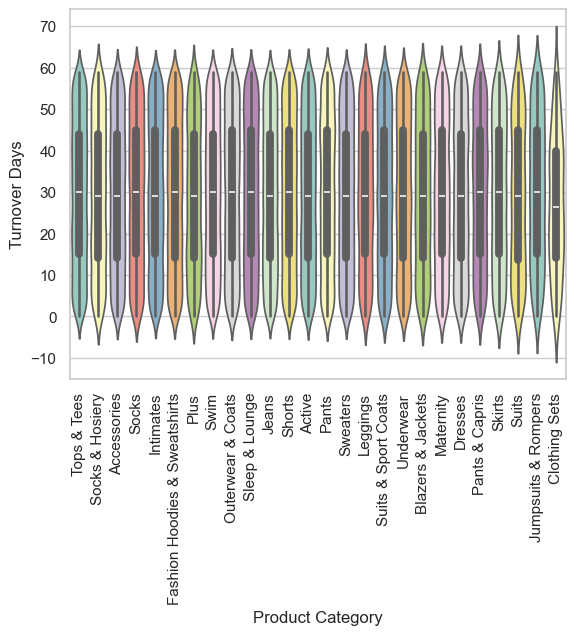

In [74]:
# Simple: Use inventory-items table
inventory_sql = """
WITH thelook_inventory_item AS (
SELECT
    id
    ,product_id
    ,created_at
    ,sold_at
    ,cost
    ,product_category
    ,product_name
    ,product_brand
    ,product_retail_price
    ,product_department
    ,product_sku
    ,product_distribution_center_id
    ,CASE WHEN sold_at IS NOT NULL THEN DATE_DIFF(sold_at,created_at,DAY) ELSE NULL END AS turnover_days
FROM
    `trumid-case.thelook_ecommerce.inventory_items`
)
SELECT
    *
FROM 
    thelook_inventory_item
WHERE
    turnover_days IS NOT NULL
"""
inventory = pandas_gbq.read_gbq(inventory_sql)
sns.violinplot(data=inventory, x='product_category', y='turnover_days',hue='product_category',palette="Set3")
plt.xlabel('Product Category')
plt.ylabel('Turnover Days')
# Rotate x-axis labels for better readability (optional)
turnover_ticks = plt.xticks(rotation=90)

### Product Profit Margin within a Product Category

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


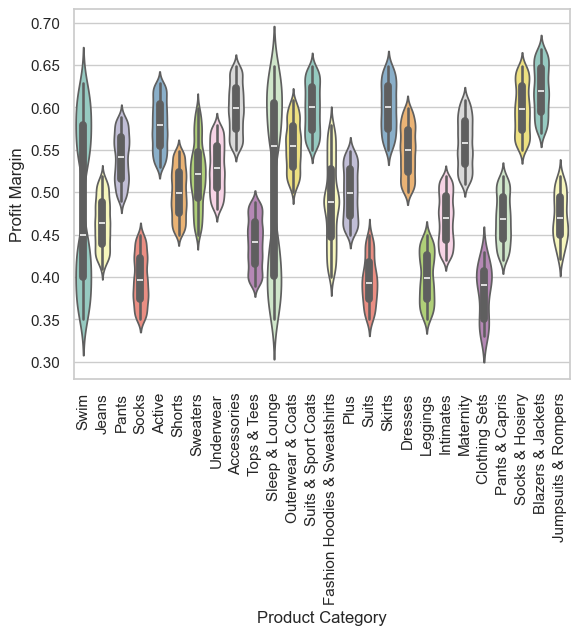

In [73]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku as product_sku
    ,cost as product_cost
    ,category as product_category
    ,name as product_name
    ,brand as product_brand
    ,retail_price
    ,department
    ,retail_price - cost AS gross_profit
    ,((retail_price - cost)*1.00)/(retail_price*1.00) AS profit_margin
FROM
    `trumid-case.thelook_ecommerce.products`
)
SELECT
    *
FROM
    thelook_products

"""
product_with_margins = pandas_gbq.read_gbq(query)
sns.violinplot(data=product_with_margins, x='product_category', y='profit_margin',hue='product_category',palette="Set3")

# Set labels for the x and y axes
plt.xlabel('Product Category')
plt.ylabel('Profit Margin')

# Rotate x-axis labels for better readability (optional)
profit_margin_ticks = plt.xticks(rotation=90)

### Analyzing Product Category Profit Margin Relative to Percent Profit & Cost, Number Sold

In [146]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
query = """
WITH thelook_order_items AS (
SELECT
    product_id
    ,status
    ,COUNT(id) as quantity
FROM
    `trumid-case.thelook_ecommerce.order_items`
GROUP BY
    product_id
    ,status
),
thelook_products AS (
SELECT
    id as product_id
    ,sku as product_sku
    ,cost as product_cost
    ,category as product_category
    ,name as product_name
    ,brand as product_brand
    ,retail_price
    ,department
    ,retail_price - cost AS gross_profit
    ,((retail_price - cost)*1.00)/(retail_price*1.00) AS profit_margin
FROM
    `trumid-case.thelook_ecommerce.products`
)
SELECT
    thelook_products.product_id
    ,thelook_products.product_category
    ,thelook_products.product_sku
    ,thelook_products.product_cost
    ,thelook_products.retail_price
    ,thelook_products.gross_profit
    ,thelook_products.profit_margin
    ,thelook_order_items.quantity
    ,COALESCE(thelook_order_items.status,'Never Ordered') as order_status
    ,COALESCE(thelook_order_items.quantity,0) as quantity
FROM
    thelook_products
LEFT JOIN
    thelook_order_items
ON
    thelook_products.product_id = thelook_order_items.product_id
"""
product_by_order_status = pandas_gbq.read_gbq(query)
product_by_order_status.groupby(['product_category','order_status']).count().query("order_status == 'Never Ordered'") # 54 products were never ordered
product_orders = product_by_order_status.query("order_status == 'Complete' | order_status == 'Shipped' | order_status == 'Processing'")
product_orders = pd.DataFrame(product_orders).reset_index()
product_orders['total_profit'] = product_orders['gross_profit'].sum()
product_orders['percent_of_profit'] = product_orders['gross_profit'] / product_orders['total_profit']
product_orders['total_cost'] = product_orders['product_cost'].sum()
product_orders['percent_of_cost'] = product_orders['product_cost'] / product_orders['total_cost']
product_orders['total_revenue'] = product_orders['retail_price'].sum()
product_orders['percent_of_revenue'] = product_orders['retail_price'] / product_orders['total_revenue']

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


Text(0.5, 0, 'Gross Profit Margin')

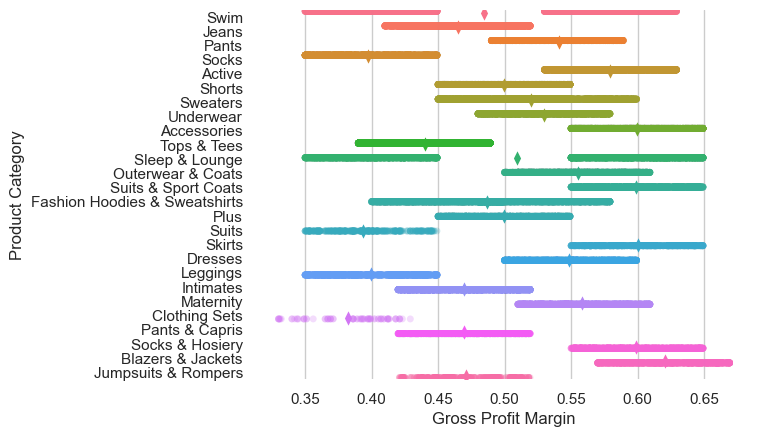

In [124]:
f, ax = plt.subplots()
sns.despine(bottom=True, left=True)
sns.stripplot(
    data=product_orders, x="profit_margin", y="product_category", hue="product_category",
    dodge=True, alpha=.25, zorder=1, legend=False,
)
sns.pointplot(
    data=product_orders, x="profit_margin", y="product_category", hue="product_category",
    dodge=.8 - .8 / 3, errorbar=None,
    markers="d", markersize=4, linestyle="none",
)
# Set labels for the x and y axes
plt.ylabel('Product Category')
plt.xlabel('Gross Profit Margin')

Text(0.5, 33.000000000000014, 'Mean Retail Price')

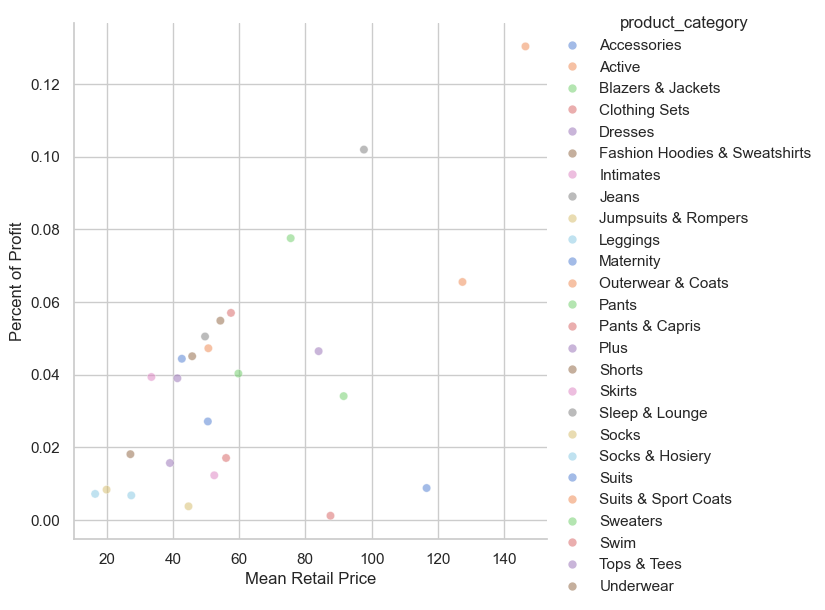

In [158]:

agg_product_details = product_orders.groupby('product_category').agg({"profit_margin": ['mean'],
                                                "retail_price": ['mean', 'sum'],
                                                "product_cost": ['mean', 'sum'],
                                                "gross_profit": ['mean', 'sum'],
                                                "quantity": ['sum']})
agg_product_details.columns = agg_product_details.columns.map('_'.join).str.strip('_')
agg_product_details = agg_product_details.reset_index()
agg_product_details['total_profit'] = agg_product_details['gross_profit_sum'].sum()
agg_product_details['percent_of_profit'] = agg_product_details['gross_profit_sum'] / agg_product_details['total_profit']
agg_product_details['total_cost'] = agg_product_details['product_cost_sum'].sum()
agg_product_details['percent_of_cost'] = agg_product_details['product_cost_sum'] / agg_product_details['total_cost']
agg_product_details['total_revenue'] = agg_product_details['retail_price_sum'].sum()
agg_product_details['percent_of_revenue'] = agg_product_details['retail_price_sum'] / agg_product_details['total_revenue']
agg_product_details['realized_profit_margin'] = agg_product_details['gross_profit_sum'] / agg_product_details['product_cost_sum']
sns.relplot(x="retail_price_mean", y="percent_of_profit", hue="product_category",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=agg_product_details)
# Set labels for the x and y axes
plt.ylabel('Percent of Profit')
plt.xlabel('Mean Retail Price')

Text(0.5, 33.000000000000014, 'Number Sold')

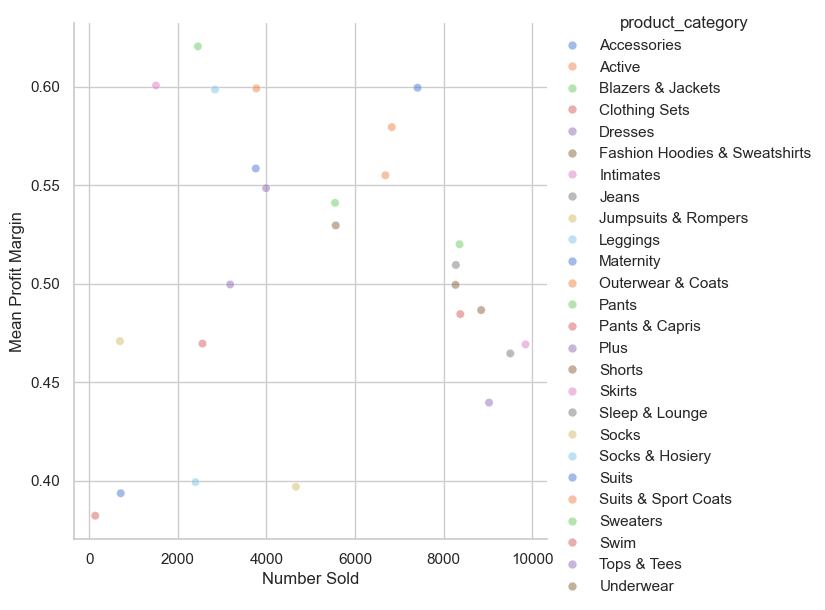

In [155]:
sns.relplot(x="quantity_sum", y="profit_margin_mean", hue="product_category",
            sizes=(40, 400), alpha=.5, palette="muted",
            height=6, data=agg_product_details)
# Set labels for the x and y axes
plt.ylabel('Mean Profit Margin')
plt.xlabel('Number Sold')

In [160]:
agg_product_details.query("percent_of_cost < percent_of_profit")[['product_category','percent_of_cost','percent_of_profit','profit_margin_mean','quantity_sum','retail_price_mean']].sort_values('percent_of_profit',ascending=False)

,product_category,percent_of_cost,percent_of_profit,profit_margin_mean,quantity_sum,retail_price_mean
11,Outerwear & Coats,0.112769,0.130323,0.554979,6685,146.416083
22,Sweaters,0.077307,0.077547,0.519988,8360,75.571912
21,Suits & Sport Coats,0.047540,0.065509,0.599021,3771,127.407939
1,Active,0.036829,0.047266,0.579399,6830,50.721518
4,Dresses,0.041154,0.046461,0.548428,3991,84.001665
0,Accessories,0.032062,0.044377,0.599383,7412,42.721926
12,Pants,0.036927,0.040301,0.540994,5548,59.786263
2,Blazers & Jackets,0.022491,0.034093,0.620348,2451,91.552874
10,Maternity,0.023109,0.027125,0.558447,3758,50.572723
25,Underwear,0.017377,0.018115,0.529548,5564,27.202461


In [159]:
agg_product_details.query("percent_of_cost > percent_of_profit")[['product_category','percent_of_cost','percent_of_profit','profit_margin_mean','retail_price_mean']].sort_values('percent_of_profit',ascending=True)

,product_category,percent_of_cost,percent_of_profit,profit_margin_mean,retail_price_mean
3,Clothing Sets,0.002066,0.001182,0.382311,87.580000
8,Jumpsuits & Rompers,0.004627,0.003770,0.470849,44.734960
9,Leggings,0.011021,0.006779,0.399358,27.463235
18,Socks,0.013763,0.008363,0.397008,20.007972
20,Suits,0.014603,0.008804,0.393708,116.585736
14,Plus,0.016950,0.015693,0.499620,39.120423
13,Pants & Capris,0.020459,0.017074,0.469619,56.073770
24,Tops & Tees,0.053606,0.039013,0.439680,41.380141
6,Intimates,0.048251,0.039361,0.469202,33.538029
15,Shorts,0.048810,0.045070,0.499410,45.842389


# Question 2

Using the `events` table, analyze the performance of TheLook’s website. Determine if there are
particular segments of traffic that overperform or underperform in terms of conversion (define
“conversion” in this context as the percentage of sessions that lead to a purchase). What
recommendations would you make to management to improve this KPI?

Using the `events` table, analyze the performance of TheLook’s website. Determine if there are particular segments of traffic that overperform or underperform in terms of conversion (define “conversion” in this context as the percentage of sessions that lead to a purchase). 

What recommendations would you make to management to improve this KPI?

## Recommendation

- The conversion rate is great as of late, but there's always room to improve
- Focus on adverstising in new markets (Instagram, TikTok) and hone in on keeping visitors beyond the first minute

## Analysis

### Examining `events` Data

- When `user_id` is null, user hasn't purchased
    - Those cases can end in `cart`, `cancel`, `product`, `department`
- When `user_id` is **not** null, ends in a purchase

In [161]:
# Event Types for Sessions without a User ID
query = """
SELECT
    event_type
    ,count(*)
FROM
     `trumid-case.thelook_ecommerce.events`
WHERE
    user_id IS NULL
GROUP BY
    event_type
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,event_type,f0_
0,cart,250542
1,cancel,124813
2,product,500000
3,department,250868


### Calculating Conversion Rate
- Create one record for session
- Since we care about the ultimate decision, use the end date as the session date

In [207]:
# Total
query = """
SELECT
    num_purchase_sessions
    ,num_sessions
    ,(num_purchase_sessions * 1.0) / (num_sessions * 1.0) AS conversion_rate
FROM
(
    SELECT
        count(distinct session_id) as num_sessions
        ,count(distinct case when event_type = 'purchase' then session_id else null end) as num_purchase_sessions
    FROM
         `trumid-case.thelook_ecommerce.events`
 )
"""
pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,num_purchase_sessions,num_sessions,conversion_rate
0,180920,680920,0.265699


In [164]:
# Monthly Conversion Rate
query = """
WITH session_aggregates AS (
SELECT
    session_id
    ,user_id
    ,MIN(DATE(created_at)) AS session_start_date
    ,MAX(DATE(created_at)) AS session_end_date
    ,MIN(sequence_number) AS first_visit_of_session
    ,MAX(sequence_number) AS last_visit_of_session
FROM
     `trumid-case.thelook_ecommerce.events`
GROUP BY
    session_id
    ,user_id
 ),
session_features AS (
SELECT
    session_aggregates.session_id
    ,session_aggregates.user_id
    ,CASE WHEN session_aggregates.user_id IS NOT NULL THEN TRUE ELSE FALSE END AS is_customer
    ,session_aggregates.session_start_date
    ,session_aggregates.session_end_date
    ,LAST_DAY(session_aggregates.session_end_date, MONTH) AS session_month
    ,CASE WHEN session_aggregates.session_start_date = session_aggregates.session_end_date THEN TRUE ELSE FALSE END AS same_day_session
    ,CASE WHEN events.sequence_number = 1 THEN 'beginning' ELSE 'end' END AS session_point
    ,events.event_type
    ,events.traffic_source
    ,events.browser
FROM
    session_aggregates
INNER JOIN
    `trumid-case.thelook_ecommerce.events` events
ON
    session_aggregates.session_id = events.session_id
AND
    ((session_aggregates.first_visit_of_session = events.sequence_number) OR (session_aggregates.last_visit_of_session = events.sequence_number))
),
session_metrics AS (
SELECT
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,same_day_session
    ,browser
    ,traffic_source
    ,MIN(CASE WHEN session_point = 'beginning' THEN event_type ELSE NULL END) AS starting_event
    ,MIN(CASE WHEN session_point = 'end' THEN event_type ELSE NULL END) AS ending_event
FROM 
    session_features
GROUP BY
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,same_day_session
    ,browser
    ,traffic_source
)
SELECT
    session_month
    ,COUNT(CASE WHEN ending_event = 'purchase' THEN session_id ELSE NULL END) AS num_purchases
    ,COUNT(*) AS num_sessions
FROM
    session_metrics
GROUP BY
    session_month
ORDER BY
    session_month
"""
monthly_conversion_rate = pandas_gbq.read_gbq(query)
monthly_conversion_rate['conversion_rate'] = monthly_conversion_rate['num_purchases'] * 1.0 / monthly_conversion_rate['num_sessions'] * 1.0

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,session_month,num_purchases,num_sessions,conversion_rate
0,2019-01-31,19,8552,0.002222
1,2019-02-28,64,7783,0.008223
2,2019-03-31,107,8768,0.012203
3,2019-04-30,164,8649,0.018962
4,2019-05-31,234,8848,0.026447


In [168]:
monthly_conversion_rate['num_purchases'].sum()

180920

In [169]:
monthly_conversion_rate['num_sessions'].sum()

680920

<Axes: xlabel='session_month', ylabel='conversion_rate'>

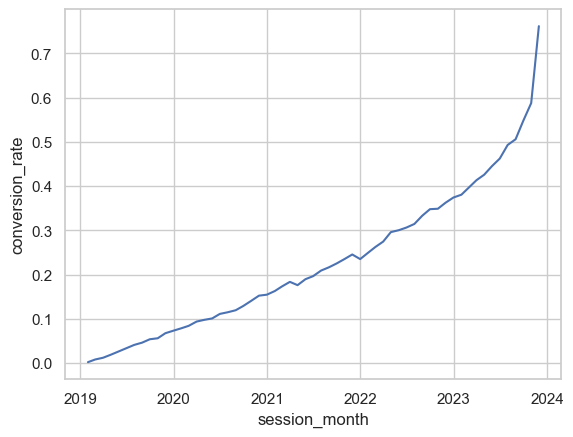

In [165]:
sns.lineplot(x="session_month", y="conversion_rate",data=monthly_conversion_rate)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


<Axes: xlabel='session_month', ylabel='conversion_rate'>

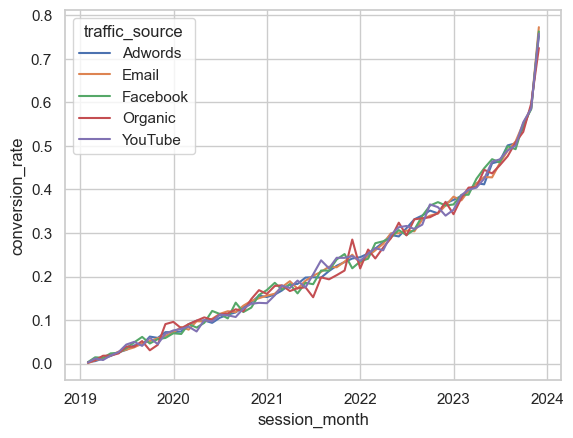

In [171]:
# TODO: Monthly Conversion Rate by Source
query = """
WITH session_aggregates AS (
SELECT
    session_id
    ,user_id
    ,MIN(DATE(created_at)) AS session_start_date
    ,MAX(DATE(created_at)) AS session_end_date
    ,MIN(sequence_number) AS first_visit_of_session
    ,MAX(sequence_number) AS last_visit_of_session
FROM
     `trumid-case.thelook_ecommerce.events`
GROUP BY
    session_id
    ,user_id
 ),
session_features AS (
SELECT
    session_aggregates.session_id
    ,session_aggregates.user_id
    ,CASE WHEN session_aggregates.user_id IS NOT NULL THEN TRUE ELSE FALSE END AS is_customer
    ,session_aggregates.session_start_date
    ,session_aggregates.session_end_date
    ,LAST_DAY(session_aggregates.session_end_date, MONTH) AS session_month
    ,CASE WHEN session_aggregates.session_start_date = session_aggregates.session_end_date THEN TRUE ELSE FALSE END AS same_day_session
    ,CASE WHEN events.sequence_number = 1 THEN 'beginning' ELSE 'end' END AS session_point
    ,events.event_type
    ,events.traffic_source
    ,events.browser
FROM
    session_aggregates
INNER JOIN
    `trumid-case.thelook_ecommerce.events` events
ON
    session_aggregates.session_id = events.session_id
AND
    ((session_aggregates.first_visit_of_session = events.sequence_number) OR (session_aggregates.last_visit_of_session = events.sequence_number))
),
session_metrics AS (
SELECT
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,same_day_session
    ,browser
    ,traffic_source
    ,MIN(CASE WHEN session_point = 'beginning' THEN event_type ELSE NULL END) AS starting_event
    ,MIN(CASE WHEN session_point = 'end' THEN event_type ELSE NULL END) AS ending_event
FROM 
    session_features
GROUP BY
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,same_day_session
    ,browser
    ,traffic_source
)
SELECT
    session_month
    ,traffic_source
    ,COUNT(CASE WHEN ending_event = 'purchase' THEN session_id ELSE NULL END) AS num_purchases
    ,COUNT(*) AS num_sessions
FROM
    session_metrics
GROUP BY
    session_month
    ,traffic_source
ORDER BY
    session_month
    ,traffic_source
"""
traffic_source_conversion_rate = pandas_gbq.read_gbq(query)
traffic_source_conversion_rate['conversion_rate'] = traffic_source_conversion_rate['num_purchases'] * 1.0 / traffic_source_conversion_rate['num_sessions'] * 1.0
sns.lineplot(x="session_month", y="conversion_rate",hue="traffic_source",data=traffic_source_conversion_rate)

In [172]:
# TODO: Overall Conversion Rate
query = """
WITH session_aggregates AS (
SELECT
    session_id
    ,user_id
    ,MIN(created_at) AS session_start
    ,MAX(created_at) AS session_end
    ,MIN(DATE(created_at)) AS session_start_date
    ,MAX(DATE(created_at)) AS session_end_date
    ,MIN(sequence_number) AS first_visit_of_session
    ,MAX(sequence_number) AS last_visit_of_session
FROM
     `trumid-case.thelook_ecommerce.events`
GROUP BY
    session_id
    ,user_id
 ),
session_features AS (
SELECT
    session_aggregates.session_id
    ,session_aggregates.user_id
    ,CASE WHEN session_aggregates.user_id IS NOT NULL THEN TRUE ELSE FALSE END AS is_customer
    ,session_aggregates.session_start_date
    ,session_aggregates.session_end_date
    ,DATETIME_DIFF(session_end,session_start,MINUTE) AS session_length_minutes
    ,LAST_DAY(session_aggregates.session_end_date, MONTH) AS session_month
    ,CASE WHEN session_aggregates.session_start_date = session_aggregates.session_end_date THEN TRUE ELSE FALSE END AS same_day_session
    ,CASE WHEN events.sequence_number = 1 THEN 'beginning' ELSE 'end' END AS session_point
    ,events.event_type
    ,events.traffic_source
    ,events.browser
FROM
    session_aggregates
INNER JOIN
    `trumid-case.thelook_ecommerce.events` events
ON
    session_aggregates.session_id = events.session_id
AND
    ((session_aggregates.first_visit_of_session = events.sequence_number) OR (session_aggregates.last_visit_of_session = events.sequence_number))
),
session_metrics AS (
SELECT
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,session_length_minutes
    ,same_day_session
    ,browser
    ,traffic_source
    ,MIN(CASE WHEN session_point = 'beginning' THEN event_type ELSE NULL END) AS starting_event
    ,MIN(CASE WHEN session_point = 'end' THEN event_type ELSE NULL END) AS ending_event
FROM 
    session_features
GROUP BY
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,session_length_minutes
    ,same_day_session
    ,browser
    ,traffic_source
)
SELECT
    session_metrics.session_id
    ,session_metrics.user_id
    ,session_metrics.is_customer
    ,session_metrics.session_month
    ,session_metrics.session_start_date
    ,session_metrics.session_end_date
    ,session_metrics.session_length_minutes
    ,session_metrics.same_day_session
    ,session_metrics.browser
    ,session_metrics.traffic_source
    ,session_metrics.starting_event
    ,COALESCE(session_metrics.ending_event,session_metrics.starting_event) AS ending_event
FROM
    session_metrics
"""
session_details = pandas_gbq.read_gbq(query)
session_details.head()

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,session_id,user_id,is_customer,session_month,session_start_date,session_end_date,session_length_minutes,same_day_session,browser,traffic_source,starting_event,ending_event
0,9de6f655-2455-45b8-ba6d-f51f1997e316,<NA>,False,2023-03-31,2023-03-28,2023-03-28,49,True,Chrome,Email,department,cart
1,e33bd532-54ba-4118-b653-a30144a72dd2,<NA>,False,2023-05-31,2023-05-19,2023-05-19,48,True,Firefox,Email,department,cart
2,a1edfc89-364a-4dfc-a53a-4445d7f11991,<NA>,False,2019-07-31,2019-07-02,2019-07-02,47,True,Chrome,Email,department,cart
3,917ad2cf-3a01-4f06-b9f8-21bc087096d1,<NA>,False,2020-09-30,2020-09-26,2020-09-26,52,True,Safari,Adwords,department,cart
4,a59ff763-ed09-46f6-992b-94e3c5d447f4,<NA>,False,2023-07-31,2023-07-02,2023-07-02,48,True,Chrome,Organic,department,cart


In [173]:
session_details.query("is_customer==True").groupby('user_id').nunique().reset_index().query("session_id > 1").sort_values('session_id',ascending=False)

,user_id,session_id,is_customer,session_month,session_start_date,session_end_date,session_length_minutes,same_day_session,browser,traffic_source,starting_event,ending_event
73769,92517,13,1,4,7,12,13,2,4,4,1,1
12193,15274,13,1,4,4,9,13,2,3,5,1,1
4118,5147,13,1,3,4,10,13,2,4,4,1,1
71875,90117,13,1,4,4,9,10,2,5,4,1,1
26257,32825,12,1,4,4,10,11,2,4,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...
22905,28631,2,1,2,2,2,2,1,2,2,1,1
52292,65502,2,1,2,2,2,1,1,2,1,1,1
52291,65501,2,1,1,1,2,2,1,2,2,1,1
52290,65499,2,1,1,1,2,2,2,2,2,1,1


In [181]:
session_sources_by_month = session_details.groupby(['is_customer','session_month','traffic_source'])[['session_id']].count().reset_index()

In [182]:
session_sources = session_details.groupby(['is_customer','traffic_source'])[['session_id']].count().reset_index()

In [183]:
54320/(54320+149785)

0.2661375272531295

In [184]:
81773/(225683+81773)

0.26596651228143214

In [185]:
17847/(49881+17847)

0.2635099220411056

In [186]:
9103/(9103+24868)

0.26796385152041446

In [187]:
18127/(18127+49783)

0.26692681490207626

In [188]:
session_ending_event_summary = session_details.groupby(['is_customer','ending_event'])[['session_id']].count().reset_index()
session_ending_event_summary

,is_customer,ending_event,session_id
0,False,cancel,124813
1,False,cart,125729
2,False,product,249458
3,True,purchase,180920


<Axes: xlabel='traffic_source', ylabel='session_id'>

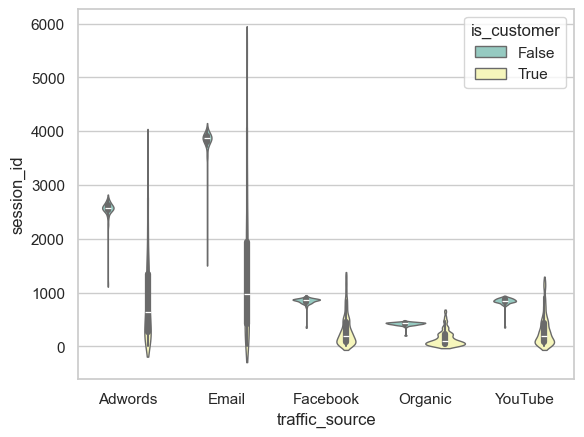

In [189]:
sns.violinplot(data=session_sources_by_month,x='traffic_source', y='session_id', hue='is_customer', bw_adjust=.5, cut=1, linewidth=1, palette="Set3")

Advertise on Instagram, TikTok


In [192]:
# TODO: Overall Conversion Rate
query = """
WITH session_aggregates AS (
SELECT
    session_id
    ,user_id
    ,MIN(created_at) AS session_start
    ,MAX(created_at) AS session_end
    ,MIN(DATE(created_at)) AS session_start_date
    ,MAX(DATE(created_at)) AS session_end_date
    ,MIN(sequence_number) AS first_visit_of_session
    ,MAX(sequence_number) AS last_visit_of_session
FROM
     `trumid-case.thelook_ecommerce.events`
GROUP BY
    session_id
    ,user_id
 ),
session_features AS (
SELECT
    session_aggregates.session_id
    ,session_aggregates.user_id
    ,CASE WHEN session_aggregates.user_id IS NOT NULL THEN TRUE ELSE FALSE END AS is_customer
    ,session_aggregates.session_start_date
    ,session_aggregates.session_end_date
    ,DATETIME_DIFF(session_end,session_start,MINUTE) AS session_length_minutes
    ,LAST_DAY(session_aggregates.session_end_date, MONTH) AS session_month
    ,CASE WHEN session_aggregates.session_start_date = session_aggregates.session_end_date THEN TRUE ELSE FALSE END AS same_day_session
    ,CASE WHEN events.sequence_number = 1 THEN 'beginning' ELSE 'end' END AS session_point
    ,events.event_type
    ,events.traffic_source
    ,events.browser
    ,events.city
    ,events.state
FROM
    session_aggregates
INNER JOIN
    `trumid-case.thelook_ecommerce.events` events
ON
    session_aggregates.session_id = events.session_id
AND
    ((session_aggregates.first_visit_of_session = events.sequence_number) OR (session_aggregates.last_visit_of_session = events.sequence_number))
),
session_metrics AS (
SELECT
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,session_length_minutes
    ,same_day_session
    ,browser
    ,traffic_source
    ,city
    ,state
    ,MIN(CASE WHEN session_point = 'beginning' THEN event_type ELSE NULL END) AS starting_event
    ,MIN(CASE WHEN session_point = 'end' THEN event_type ELSE NULL END) AS ending_event
FROM 
    session_features
GROUP BY
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,session_length_minutes
    ,same_day_session
    ,browser
    ,traffic_source
    ,city
    ,state
),
users AS (
SELECT
    id
    ,age
    ,gender
    ,country
    ,traffic_source
FROM
    `trumid-case.thelook_ecommerce.users`
),
user_sessions AS (
SELECT
    session_metrics.session_id
    ,session_metrics.user_id
    ,session_metrics.is_customer
    ,session_metrics.session_month
    ,session_metrics.session_start_date
    ,session_metrics.session_end_date
    ,session_metrics.same_day_session
    ,session_metrics.browser
    ,session_metrics.traffic_source
    ,session_metrics.starting_event
    ,COALESCE(session_metrics.ending_event,session_metrics.starting_event) AS ending_event
    ,session_metrics.session_length_minutes
    ,users.age
    ,users.gender
    ,users.country
    ,users.traffic_source AS user_traffic_sources
    ,session_metrics.city
    ,session_metrics.state
FROM
    session_metrics
LEFT JOIN
    users
ON
    session_metrics.user_id = users.id
)
SELECT
    *
FROM
    user_sessions
"""
df = pandas_gbq.read_gbq(query)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


<Axes: xlabel='traffic_source', ylabel='session_length_minutes'>

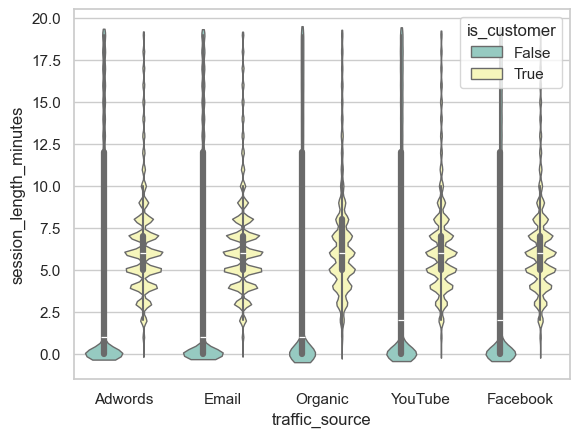

In [199]:
sns.violinplot(data=df.query("session_length_minutes < 20"),x='traffic_source', y='session_length_minutes', hue='is_customer', bw_adjust=.5, cut=1, linewidth=1, palette="Set3")

In [203]:
df.query("session_length_minutes <= 2 & is_customer == False").groupby(['ending_event'])[['session_id']].count().reset_index()

,ending_event,session_id
0,cancel,834
1,cart,867
2,product,136916


In [210]:
# TODO: Overall Conversion Rate
query = """
WITH session_aggregates AS (
SELECT
    session_id
    ,user_id
    ,MIN(DATE(created_at)) AS session_start_date
    ,MAX(DATE(created_at)) AS session_end_date
    ,MIN(sequence_number) AS first_visit_of_session
    ,MAX(sequence_number) AS last_visit_of_session
FROM
     `trumid-case.thelook_ecommerce.events`
GROUP BY
    session_id
    ,user_id
 ),
session_features AS (
SELECT
    session_aggregates.session_id
    ,session_aggregates.user_id
    ,CASE WHEN session_aggregates.user_id IS NOT NULL THEN TRUE ELSE FALSE END AS is_customer
    ,session_aggregates.session_start_date
    ,session_aggregates.session_end_date
    ,LAST_DAY(session_aggregates.session_end_date, MONTH) AS session_month
    ,CASE WHEN session_aggregates.session_start_date = session_aggregates.session_end_date THEN TRUE ELSE FALSE END AS same_day_session
    ,CASE WHEN events.sequence_number = 1 THEN 'beginning' ELSE 'end' END AS session_point
    ,events.event_type
    ,events.traffic_source
    ,events.browser
FROM
    session_aggregates
INNER JOIN
    `trumid-case.thelook_ecommerce.events` events
ON
    session_aggregates.session_id = events.session_id
AND
    ((session_aggregates.first_visit_of_session = events.sequence_number) OR (session_aggregates.last_visit_of_session = events.sequence_number))
),
session_metrics AS (
SELECT
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,same_day_session
    ,browser
    ,traffic_source
    ,MIN(CASE WHEN session_point = 'beginning' THEN event_type ELSE NULL END) AS starting_event
    ,MIN(CASE WHEN session_point = 'end' THEN event_type ELSE NULL END) AS ending_event
FROM 
    session_features
GROUP BY
    session_id
    ,user_id
    ,is_customer
    ,session_month
    ,session_start_date
    ,session_end_date
    ,same_day_session
    ,browser
    ,traffic_source
) -- JOIN TO PRODUCTS TO SEE WHAT'S BEING DESERTED
"""
monthly_conversion_rate_agg = pandas_gbq.read_gbq(query)
monthly_conversion_rate_agg['conversion_rate'] = monthly_conversion_rate_agg['num_purchases'] * 1.0 / monthly_conversion_rate_agg['num_sessions'] * 1.0
monthly_conversion_rate_agg.head()

GenericGBQException: Reason: 400 Syntax error: Unexpected end of script at [64:1]

Location: US
Job ID: 39f292b8-f087-4eb9-9e4f-4fe0d9b91629


# Question 3

The management team at TheLook has become concerned about the rate at which customers
are returning items they’ve purchased. Find out whether there is a primary driver or set of
drivers for returns and offer recommendations for how to address them.

## Recommendation

To lower the return rate, the company should focus on improving the overall shopper experience. Returns are highest among a subset of product categories. While it can be difficult to harness the why with data available, testing features likesize comparison or fit estimate could improve the liklihood a product is kept.

* The time it takes for customers to receive orders is similar for both returns and non-returns
* Some demographics have slightly higher returns rates than others (40- & 60-year olds, Men) but nothing that indicates a problem
* You see the most variance in product category. Jumpsuits & Rompers and Clothing Sets have the highest rate of return. We already suggested selling less Clothing Sets so focus on Rompers. Other items owrth evaluating are Skirts, Leggings, Pants & Capri, and Plus


## Analysis

### Return Rate Over Time

- Where are we today? How does that context in context?

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


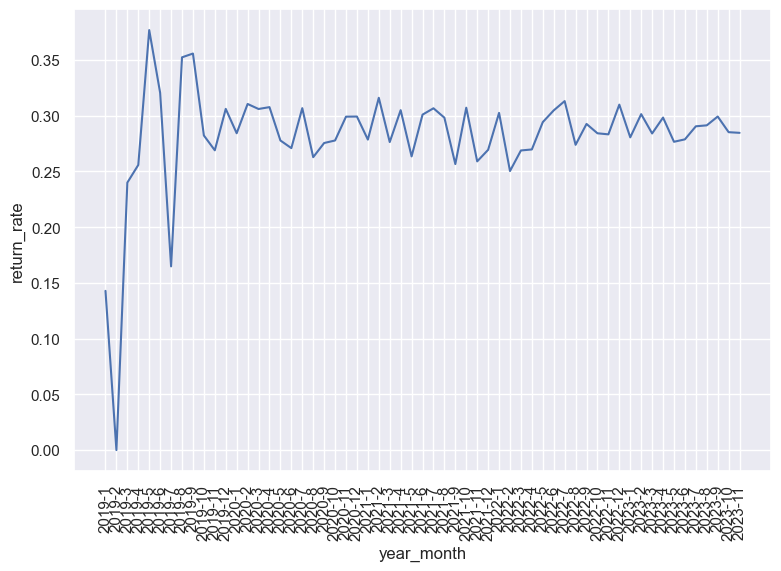

In [230]:
return_rate_by_month_sql = """
WITH thelook_order_details AS (
SELECT
    orders.order_id
    ,orders.user_id
    ,orders.num_of_item
    ,orders.status AS order_status
    ,users.age
    ,users.email
    ,SPLIT(users.email, '@')[SAFE_OFFSET(1)] as domain
    ,users.country
    ,users.gender
    ,users.traffic_source
    ,DATE(orders.created_at) AS order_date
    ,CASE WHEN orders.status = 'Returned' THEN TRUE ELSE FALSE END AS is_return
    ,SUM(order_items.sale_price) AS order_revenue
    ,COUNT(order_items.id) AS num_items
FROM
    `trumid-case.thelook_ecommerce.orders`  AS orders
LEFT JOIN
    `trumid-case.thelook_ecommerce.order_items` AS order_items
ON
    orders.order_id = order_items.order_id
LEFT JOIN
    `trumid-case.thelook_ecommerce.users`  AS users
ON
    orders.user_id = users.id
GROUP BY
    orders.order_id
    ,orders.user_id
    ,orders.num_of_item
    ,orders.status
    ,users.age
    ,users.email
    ,SPLIT(users.email, '@')[SAFE_OFFSET(1)]
    ,users.country
    ,users.gender
    ,users.traffic_source
    ,DATE(orders.created_at)
),
completed_returned_only AS (
SELECT
    *
    ,EXTRACT(MONTH FROM order_date) AS order_month
    ,EXTRACT(YEAR FROM order_date) AS order_year
    ,CAST(EXTRACT(YEAR FROM order_date) AS STRING)||'-'||CAST(EXTRACT(MONTH FROM order_date) AS STRING) AS year_month
FROM 
    thelook_order_details
WHERE
    order_status IN ('Complete', 'Returned')
),
thelook_agg_return_metrics AS (
SELECT
    order_year
    ,order_month
    ,year_month
    ,COUNT(CASE WHEN is_return IS TRUE THEN order_id ELSE NULL END) AS num_returns
    ,COUNT(CASE WHEN is_return IS FALSE THEN order_id ELSE NULL END) AS num_completed
    ,COUNT(order_id) AS total
FROM
    completed_returned_only
GROUP BY
    order_year
    ,order_month
    ,year_month
)
SELECT
    * 
    ,(num_returns * 1.0) / (total * 1.0) AS return_rate
FROM 
    thelook_agg_return_metrics
ORDER BY
    order_year
    ,order_month ASC
"""
return_rate_by_month = pandas_gbq.read_gbq(return_rate_by_month_sql)
sns.set_theme(style="darkgrid")

# Plot the responses for different events and regions
fig, axes = plt.subplots(figsize=(9, 6))
sns.lineplot(x="year_month", y="return_rate",data=return_rate_by_month)

return_rate_ticks = plt.xticks(rotation=90)


### Is time to delivery a factor?

- Using date from the orders table, calculate time to ship and deliver. Is there a difference when items are returned?

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


([0, 1], [Text(0, 0, 'False'), Text(1, 0, 'True')])

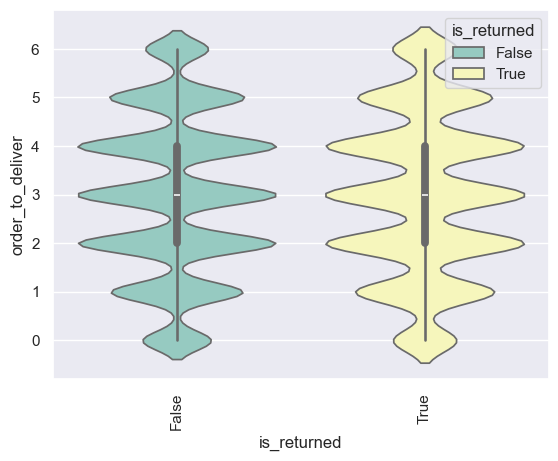

In [234]:
# Join with orders to get user_id, product to get category and desc can't rely on inventory table for dist location, can I?
# Check by user, product category, price, time, etc. 
# Metric is frequency of return by X
query = """
WITH thelook_orderitem_details AS (
SELECT
    order_items.id AS order_item_id
    ,products.id AS product_id
    ,orders.order_id AS order_id
    ,users.id AS user_id
    ,order_items.status AS order_item_status
    ,orders.status AS order_status
    ,products.category AS product_category
    ,products.brand AS product_brand
    ,products.name AS product_name
    ,products.department AS product_department
    ,products.distribution_center_id AS product_distribution_center_id
    ,orders.created_at AS order_created_at
    ,order_items.shipped_at AS order_item_shipped_at
    ,order_items.delivered_at AS order_item_delivered_at
    ,order_items.returned_at AS order_item_returned_at
    ,products.cost AS product_cost
    ,products.retail_price AS product_sale_price
FROM
    `trumid-case.thelook_ecommerce.order_items` order_items
LEFT JOIN
    `trumid-case.thelook_ecommerce.orders` orders
ON
    order_items.order_id = orders.order_id
LEFT JOIN
    `trumid-case.thelook_ecommerce.users` users
ON
    orders.user_id = users.id
LEFT JOIN
    `trumid-case.thelook_ecommerce.products` products
ON
    order_items.product_id = products.id
),
thelook_return_metrics AS (
SELECT
    order_item_id
    ,product_id
    ,order_id
    ,user_id
    ,order_item_status
    ,order_status
    ,product_category
    ,product_brand
    ,product_name
    ,product_department
    ,product_distribution_center_id
    ,order_created_at
    ,order_item_shipped_at
    ,order_item_delivered_at
    ,order_item_returned_at
    ,product_cost
    ,product_sale_price
    ,CASE
        WHEN order_item_shipped_at IS NOT NULL
        THEN DATE_DIFF(order_item_shipped_at,order_created_at,DAY) 
        ELSE NULL END AS order_to_ship
    ,CASE 
        WHEN order_item_delivered_at IS NOT NULL
        THEN DATE_DIFF(order_item_delivered_at,order_item_shipped_at,DAY)
        ELSE NULL END AS ship_to_deliver
    ,CASE 
        WHEN order_item_returned_at IS NOT NULL
        THEN DATE_DIFF(order_item_returned_at,order_item_delivered_at,DAY)
        ELSE NULL END AS deliver_to_return
    ,CASE 
        WHEN order_item_returned_at IS NOT NULL THEN TRUE ELSE FALSE END AS is_returned
FROM
    thelook_orderitem_details
/*
WHERE
    order_item_status IN ('Complete','Returned')
*/
),
thelook_agg_return_metrics AS (
SELECT
    is_returned
    ,order_item_id
    ,product_category
    ,product_distribution_center_id
    ,product_brand
    ,product_name
    ,product_department
    ,ship_to_deliver
    ,order_to_ship
    ,order_to_ship + ship_to_deliver AS order_to_deliver
FROM
    thelook_return_metrics
)
SELECT * FROM thelook_agg_return_metrics
"""
return_metrics = pandas_gbq.read_gbq(query)
sns.violinplot(data=return_metrics, x='is_returned', y='order_to_deliver',hue='is_returned',palette="Set3")
# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=90)

### Does demographic features like age or gender play a factor?

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


/var/folders/w8/8ywl8kgs1dj17b9910td3z440000gn/T/ipykernel_7300/4193494480.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=age, x='decade', y='return_rate', palette="Set3")


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, '6'),
  Text(1, 0, '5'),
  Text(2, 0, '3'),
  Text(3, 0, '1'),
  Text(4, 0, '2'),
  Text(5, 0, '4'),
  Text(6, 0, '7')])

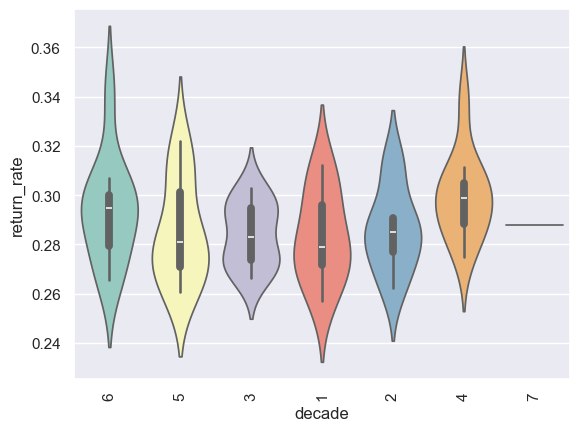

In [241]:
# Join with orders to get user_id, product to get category and desc can't rely on inventory table for dist location, can I?
# Check by user, product category, price, time, etc. 
# Metric is frequency of return by X
query = """
WITH thelook_orderitem_details AS (
SELECT
    order_items.id AS order_item_id
    ,products.id AS product_id
    ,orders.order_id AS order_id
    ,users.id AS user_id
    ,order_items.status AS order_item_status
    ,orders.status AS order_status
    ,products.category AS product_category
    ,products.brand AS product_brand
    ,products.name AS product_name
    ,products.department AS product_department
    ,products.distribution_center_id AS product_distribution_center_id
    ,orders.created_at AS order_created_at
    ,order_items.shipped_at AS order_item_shipped_at
    ,order_items.delivered_at AS order_item_delivered_at
    ,order_items.returned_at AS order_item_returned_at
    ,products.cost AS product_cost
    ,products.retail_price AS product_sale_price
    ,users.gender AS user_gender
    ,users.country AS user_country
    ,users.age AS user_age
FROM
    `trumid-case.thelook_ecommerce.order_items` order_items
LEFT JOIN
    `trumid-case.thelook_ecommerce.orders` orders
ON
    order_items.order_id = orders.order_id
LEFT JOIN
    `trumid-case.thelook_ecommerce.users` users
ON
    orders.user_id = users.id
LEFT JOIN
    `trumid-case.thelook_ecommerce.products` products
ON
    order_items.product_id = products.id
),
thelook_return_metrics AS (
SELECT
    order_item_id
    ,product_id
    ,order_id
    ,user_id
    ,order_item_status
    ,order_status
    ,product_category
    ,product_brand
    ,product_name
    ,product_department
    ,product_distribution_center_id
    ,order_created_at
    ,order_item_shipped_at
    ,order_item_delivered_at
    ,order_item_returned_at
    ,product_cost
    ,product_sale_price
    ,user_gender
    ,user_country
    ,user_age
    ,CASE WHEN order_item_returned_at IS NOT NULL THEN TRUE ELSE FALSE END AS is_returned
FROM
    thelook_orderitem_details
WHERE
    order_item_status IN ('Complete', 'Returned')
),
thelook_agg_return_metrics AS (
SELECT
    user_age
    ,COUNT(CASE WHEN is_returned IS TRUE THEN order_item_id ELSE NULL END) AS num_returns
    ,COUNT(CASE WHEN is_returned IS FALSE THEN order_item_id ELSE NULL END) AS num_completed
    ,COUNT(order_item_id) AS total
FROM
    thelook_return_metrics
GROUP BY
    user_age
)
SELECT
    * 
    ,LEFT(CAST(user_age AS STRING),1) AS decade
    ,(num_returns * 1.0) / (total * 1.0) AS return_rate
FROM 
    thelook_agg_return_metrics
"""
age = pandas_gbq.read_gbq(query)
sns.violinplot(data=age, x='decade', y='return_rate', palette="Set3")
# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=90)

In [242]:
# Join with orders to get user_id, product to get category and desc can't rely on inventory table for dist location, can I?
# Check by user, product category, price, time, etc. 
# Metric is frequency of return by X
query = """
WITH thelook_orderitem_details AS (
SELECT
    order_items.id AS order_item_id
    ,products.id AS product_id
    ,orders.order_id AS order_id
    ,users.id AS user_id
    ,order_items.status AS order_item_status
    ,orders.status AS order_status
    ,products.category AS product_category
    ,products.brand AS product_brand
    ,products.name AS product_name
    ,products.department AS product_department
    ,products.distribution_center_id AS product_distribution_center_id
    ,orders.created_at AS order_created_at
    ,order_items.shipped_at AS order_item_shipped_at
    ,order_items.delivered_at AS order_item_delivered_at
    ,order_items.returned_at AS order_item_returned_at
    ,products.cost AS product_cost
    ,products.retail_price AS product_sale_price
    ,users.gender AS user_gender
    ,users.country AS user_country
    ,users.age AS user_age
FROM
    `trumid-case.thelook_ecommerce.order_items` order_items
LEFT JOIN
    `trumid-case.thelook_ecommerce.orders` orders
ON
    order_items.order_id = orders.order_id
LEFT JOIN
    `trumid-case.thelook_ecommerce.users` users
ON
    orders.user_id = users.id
LEFT JOIN
    `trumid-case.thelook_ecommerce.products` products
ON
    order_items.product_id = products.id
),
thelook_return_metrics AS (
SELECT
    order_item_id
    ,product_id
    ,order_id
    ,user_id
    ,order_item_status
    ,order_status
    ,product_category
    ,product_brand
    ,product_name
    ,product_department
    ,product_distribution_center_id
    ,order_created_at
    ,order_item_shipped_at
    ,order_item_delivered_at
    ,order_item_returned_at
    ,product_cost
    ,product_sale_price
    ,user_gender
    ,user_country
    ,user_age
    ,CASE WHEN order_item_returned_at IS NOT NULL THEN TRUE ELSE FALSE END AS is_returned
FROM
    thelook_orderitem_details
WHERE
    order_item_status IN ('Complete', 'Returned')
),
thelook_agg_return_metrics AS (
SELECT
    product_department
    ,product_category
    ,COUNT(CASE WHEN is_returned IS TRUE THEN order_item_id ELSE NULL END) AS num_returns
    ,COUNT(CASE WHEN is_returned IS FALSE THEN order_item_id ELSE NULL END) AS num_completed
    ,COUNT(order_item_id) AS total
FROM
    thelook_return_metrics
GROUP BY
    product_department
    ,product_category
)
SELECT
    * 
    --,LEFT(CAST(user_age AS STRING),1) AS decade
    ,(num_returns * 1.0) / (total * 1.0) AS return_rate
FROM 
    thelook_agg_return_metrics
"""
users = pandas_gbq.read_gbq(query)
users.sort_values('return_rate',ascending=False)#.query("return_rate > 0 & return_rate < 1")

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,product_department,product_category,num_returns,num_completed,total,return_rate
34,Women,Clothing Sets,28,46,74,0.378378
21,Women,Jumpsuits & Rompers,113,214,327,0.345566
32,Men,Outerwear & Coats,617,1344,1961,0.314635
0,Women,Accessories,471,1045,1516,0.310686
25,Women,Outerwear & Coats,375,842,1217,0.308135
5,Men,Active,564,1280,1844,0.305857
16,Men,Sleep & Lounge,656,1493,2149,0.305258
28,Men,Suits & Sport Coats,528,1241,1769,0.298474
10,Women,Shorts,486,1151,1637,0.296885
29,Men,Swim,641,1521,2162,0.296485


([0, 1], [Text(0, 0, 'Women'), Text(1, 0, 'Men')])

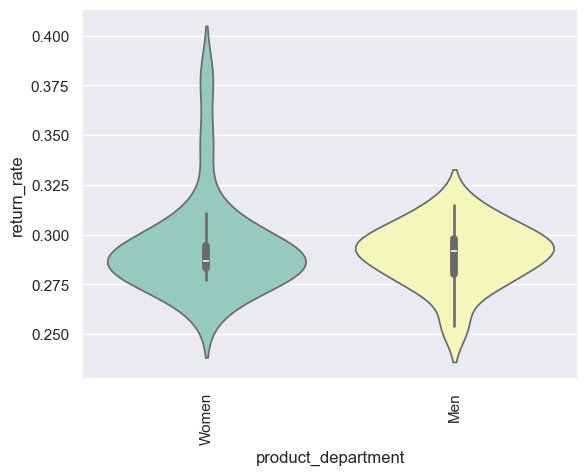

In [243]:
sns.violinplot(data=users, x='product_department', y='return_rate',hue = 'product_department', palette="Set3")
# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=90)

In [221]:
# TODO: Make CTEs a string with ability to pass SELECT underneath
aov_aop_sql = """
WITH thelook_order_details AS (
SELECT
    orders.order_id
    ,orders.user_id
    ,orders.num_of_item
    ,orders.status AS order_status
    ,users.age
    ,users.email
    ,SPLIT(users.email, '@')[SAFE_OFFSET(1)] as domain
    ,users.country
    ,users.gender
    ,users.traffic_source
    ,DATE(orders.created_at) AS order_date
    ,CASE WHEN orders.status = 'Returned' THEN TRUE ELSE FALSE END AS is_return
    ,SUM(order_items.sale_price) AS order_revenue
    ,COUNT(order_items.id) AS num_items
FROM
    `trumid-case.thelook_ecommerce.orders`  AS orders
LEFT JOIN
    `trumid-case.thelook_ecommerce.order_items` AS order_items
ON
    orders.order_id = order_items.order_id
LEFT JOIN
    `trumid-case.thelook_ecommerce.users`  AS users
ON
    orders.user_id = users.id
GROUP BY
    orders.order_id
    ,orders.user_id
    ,orders.num_of_item
    ,orders.status
    ,users.age
    ,users.email
    ,SPLIT(users.email, '@')[SAFE_OFFSET(1)]
    ,users.country
    ,users.gender
    ,users.traffic_source
    ,DATE(orders.created_at)
),
completed_returned_only AS (
SELECT
    *
    ,EXTRACT(MONTH FROM order_date) AS order_month
    ,EXTRACT(YEAR FROM order_date) AS order_year
    ,CAST(EXTRACT(YEAR FROM order_date) AS STRING)||'-'||CAST(EXTRACT(MONTH FROM order_date) AS STRING) AS year_month
FROM 
    thelook_order_details
WHERE
    order_status IN ('Complete', 'Returned')
)
SELECT
    is_return
    ,year_month
    ,COUNT(order_id) AS num_orders
    ,AVG(order_revenue) AS average_order_value
    ,SUM(num_of_item) AS item_count_prog
    ,SUM(num_items) AS item_count_man 
FROM 
    completed_returned_only
GROUP BY
    is_return
    ,year_month
"""
aov_aop = pandas_gbq.read_gbq(aov_aop_sql)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


In [227]:
aov_aop

,is_return,year_month,num_orders,average_order_value,item_count_prog,item_count_man
59,True,2022-7,289,89.162976,419,419
60,True,2022-5,266,85.234962,384,384
61,True,2021-6,158,98.437595,251,251
62,True,2023-8,634,85.695931,928,928
63,True,2020-7,77,72.722467,103,103
64,True,2023-7,599,82.591185,854,854
65,True,2023-4,466,85.334206,657,657
66,True,2021-12,184,80.908261,246,246
67,True,2021-8,184,95.546141,288,288
68,True,2021-7,161,84.942609,251,251


### Are some brands returned more than others? **Yes but relationship is consistent**

In [253]:
returns_by_brand_sql = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku
    ,brand
    ,category
FROM
    `trumid-case.thelook_ecommerce.products`
),
thelook_orderitems AS (
SELECT
    id as order_item_id
    ,product_id
FROM
    `trumid-case.thelook_ecommerce.order_items`
WHERE
    status = 'Returned'
),
thelook_revenue AS (
SELECT
   thelook_products.product_id
   ,thelook_products.brand
   ,thelook_products.category
   ,thelook_orderitems.order_item_id
FROM
    thelook_products
INNER JOIN
    thelook_orderitems
ON
    thelook_products.product_id = thelook_orderitems.product_id
)
SELECT
    category
    ,brand
    ,COUNT(order_item_id) AS num_returns
FROM
    thelook_revenue
GROUP BY
    category
    ,brand
"""
returns_by_brand = pandas_gbq.read_gbq(returns_by_brand_sql)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,category,brand,num_returns
44,Swim,Speedo,118
3115,Maternity,Motherhood Maternity,108
157,Jeans,Levi's,103
200,Jeans,7 For All Mankind,103
3796,Blazers & Jackets,Allegra K,95
...,...,...,...
1399,Sleep & Lounge,Wxy,1
2813,Sweaters,Alfani,1
2812,Sweaters,bebe,1
1402,Sleep & Lounge,Pull-in,1


In [254]:
orders_by_brand_sql = """
WITH thelook_products AS (
SELECT
    id as product_id
    ,sku
    ,brand
    ,category
FROM
    `trumid-case.thelook_ecommerce.products`
),
thelook_orderitems AS (
SELECT
    id as order_item_id
    ,product_id
FROM
    `trumid-case.thelook_ecommerce.order_items`
WHERE
    status IN ('Complete','Returned')
),
thelook_revenue AS (
SELECT
   thelook_products.product_id
   ,thelook_products.brand
   ,thelook_products.category
   ,thelook_orderitems.order_item_id
FROM
    thelook_products
INNER JOIN
    thelook_orderitems
ON
    thelook_products.product_id = thelook_orderitems.product_id
)
SELECT
    category
    ,brand
    ,COUNT(order_item_id) AS num_order_items
FROM
    thelook_revenue
GROUP BY
    category
    ,brand
"""
orders_by_brand = pandas_gbq.read_gbq(orders_by_brand_sql)

Downloading: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████|


,category,brand,num_order_items
61,Swim,Speedo,441
4236,Maternity,Motherhood Maternity,368
258,Jeans,7 For All Mankind,338
198,Jeans,Levi's,333
5234,Blazers & Jackets,Allegra K,314
...,...,...,...
157,Jeans,Analog,1
4482,Accessories,Pop Fashionwear,1
4481,Accessories,Cowboy Shop,1
5049,Socks & Hosiery,Zoot,1


In [269]:
category_brand = pd.merge(orders_by_brand,returns_by_brand,on=['category','brand'],how='inner')
category_brand['return_rate'] = category_brand['num_returns'] * 1.0 / category_brand['num_order_items'] * 1.0
category_brand.sort_values('return_rate',ascending=False).query("num_order_items > 10")

,category,brand,num_order_items,num_returns,return_rate
2939,Intimates,Carol Wright Gifts,13,10,0.769231
900,Sweaters,Psycho Bunny,13,9,0.692308
398,Socks,Original Penguin,14,9,0.642857
3721,Socks & Hosiery,Steve Madden,14,9,0.642857
3163,Maternity,Ingrid & Isabel,18,11,0.611111
...,...,...,...,...,...
3825,Outerwear & Coats,laundry by SHELLI SEGAL,14,1,0.071429
2927,Intimates,CorsetDeal,16,1,0.0625
3035,Intimates,Lipo in a Box,16,1,0.0625
617,Active,ZeroGravitee,18,1,0.055556


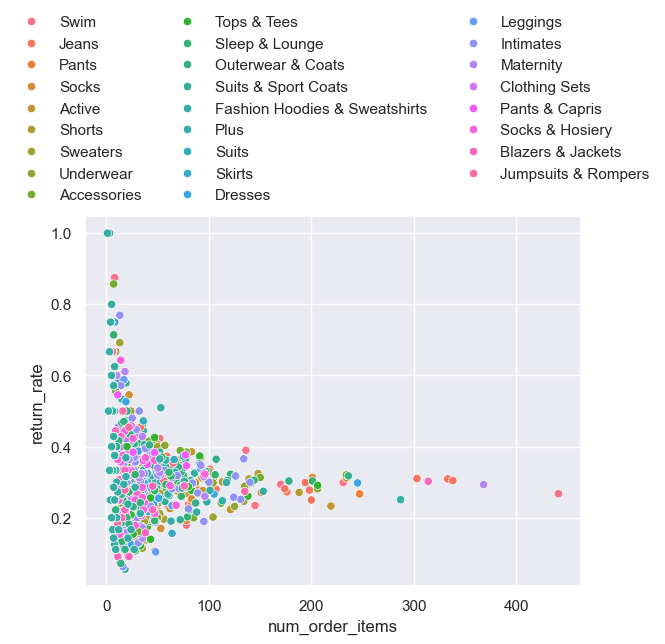

In [283]:
a = sns.scatterplot(data=category_brand, x="num_order_items", y="return_rate",hue='category')
sns.move_legend(
    a, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

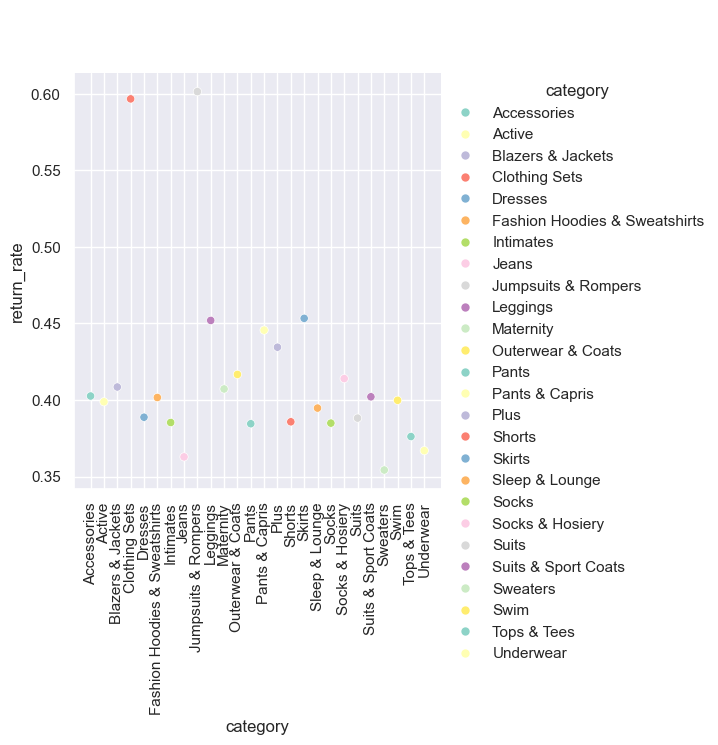

In [278]:
category = category_brand[['category','return_rate']].groupby('category').mean().reset_index()
sns.relplot(data=category, x='category', y='return_rate',hue = 'category', palette="Set3")
# Rotate x-axis labels for better readability (optional)
category_ticks = plt.xticks(rotation=90)

In [279]:
category.sort_values('return_rate',ascending=False)

,category,return_rate
8,Jumpsuits & Rompers,0.601444
3,Clothing Sets,0.596677
16,Skirts,0.453354
9,Leggings,0.452004
13,Pants & Capris,0.445652
14,Plus,0.434503
11,Outerwear & Coats,0.416721
19,Socks & Hosiery,0.414005
2,Blazers & Jackets,0.408512
10,Maternity,0.407236
